<a href="https://colab.research.google.com/github/vjha-gams/google_colab/blob/main/docs/user/notebooks/trnsport_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick Start Guide

## Introduction

This quick start guide is designed to provide you with a concise overview of GAMSPy and its key features. By the end of this guide, you'll have a solid understanding of how to create basic mathematical models using GAMSPy. For more advanced features, we recommend exploring our comprehensive [user guide](https://gamspy.readthedocs.io/en/latest/user/index.html) and the extensive [model library](https://github.com/GAMS-dev/gamspy-examples).

While not mandatory, having a basic understanding of Python programming and familiarity with the [Pandas library](https://pandas.pydata.org/) will be helpful for following this tutorial.

## A Transportation Problem

In this guide, we'll delve into an example of the transportation problem. This classic scenario involves managing supplies from various plants to meet demands at multiple markets for a single commodity. Additionally, we have the unit costs associated with shipping the commodity from plants to markets. The fundamental economic question here is:

> How can we optimize the shipment quantities between each plant and market to minimize the total transport cost?

The problem's algebraic representation typically takes the following format:

Indices (Sets):

- $i$ = plants
- $j$ = markets

Given Data (Parameters):

- $a_i$ = supply of commodity at plant $i$ (in cases)
- $b_j$ = demand for commodity at market $j$ (in cases)
- $c_{ij}$ = cost per unit of shipment between plant $i$ and market $j$

Decision Variables:

- $x_{ij}$ = amount of commodity to ship from plant $i$ to market $j$ where $x_{ij} \ge 0$ for all $i,j$

Constraints:

- Observe supply limit at plant $i$: $\sum_j x_{ij} \le a_i \: \forall i$
- Satisfy demand at market $j$: $\sum_i x_{ij} \ge b_j \: \forall j$
- Objective Function: Minimize $\sum_i \sum_j c_{ij} \cdot x_{ij}$


## Symbol Declaration

In line with our systematic breakdown of the transportation problem into sets, parameters, variables, and constraints, we will adopt a similar approach to define the problem as a GAMSPy `Model`. To do so, it is essential to import the `gamspy` library initially.

In [2]:
# Install dependencies
! pip install -q gamspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 MB 10.2 MB/s eta 0:00:00


In [3]:
from gamspy import Container, Set, Parameter, Variable, Equation, Model, Sum, Sense, Options

### Container

Before we proceed further, let's create a `Container` to encapsulate all the relevant information for our GAMSPy ``Model``. This ``Container`` acts as a centralized hub, gathering essential data, sets, parameters, variables, and constraints, providing a clear structure for our optimization problem.

In [4]:
m = Container()

### Sets

Sets serve as the fundamental building blocks of a GAMSPy ``Model``, directly corresponding to the indices in the algebraic representations of models. In our transportation problem context, we have defined the following indices:

- $i$ = plants
- $j$ = markets

For detailed guidance on using sets, please refer to the [set section](https://gamspy.readthedocs.io/en/latest/user/basics/set.html) of our user guide.

In [5]:
i = Set(container=m, name="i", description="plants")
j = Set(container=m, name="j", description="markets")
i.name, j.name

('i', 'j')

The effect of using the above `Set` statements is that we declared two sets, namely $i$ and $j$. Additionally, we provided descriptions to elaborate on their meaning, enhancing the readability of our ``Model``. ``name`` argument of symbol constructors is optional. If the name is not provided, GAMSPy will generate a name for it automatically. Example of a symbol with an autogenerated name:

In [6]:
dummy_symbol = Set(container=m)
dummy_symbol.name

's0ceb2663_adc8_4cdd_9c6d_4e6e5e335cdf'

Providing a name to a symbol is highly recommended for many purposes. For example, if you want to reach to the symbol object via Container later in your script, you can get it with ``container['your_symbol_name']``. It is also important for interoperability which will be explained later.  

### Parameters

Parameters are declared using the `Parameter` class. Each parameter is assigned a name and a description.  Note that parameter $a_i$ is indexed by $i$. To accommodate these indices, we include the `domain` attribute, pointing to the corresponding set.

In [7]:
a = Parameter(
    container=m,
    name="a",
    domain=i,
    description="supply of commodity at plant i (in cases)"
)
b = Parameter(
    container=m,
    name="b",
    domain=j,
    description="demand for commodity at market j (in cases)"
)
c = Parameter(
    container=m,
    name="c",
    domain=[i, j],
    description="cost per unit of shipment between plant i and market j",
)

### Variables

GAMSPy variables are declared using `Variable`. Each ``Variable`` is assigned a name, a domain if necessary, a type, and, optionally, a description.

In [8]:
x = Variable(
    container=m,
    name="x",
    domain=[i, j],
    type="Positive",
    description="amount of commodity to ship from plant i to market j",
)

This statement results in the declaration of a shipment variable for each (i,j) pair.

More information on variables can be found in the [variable section](https://gamspy.readthedocs.io/en/latest/user/basics/variable.html) of our user guide.

## Equations
A GAMSPy ``Equation`` can be declared and defined in two separate statements (see [here](https://gamspy.readthedocs.io/en/latest/user/basics/equation.html#combining-equation-declaration-and-definition) how to do this in one statement). The format of the declaration is the same as for other GAMSPy symbols. First comes the keyword, `Equation` in this case, followed by the name, domain and text. The transportation problem has two constraints:

Supply: observe supply limit at plant $i$: $\sum_j x_{ij} \le a_i \: \forall i$

Demand: satisfy demand at market $j$: $\sum_i x_{ij} \ge b_j \: \forall j$

In [9]:
supply = Equation(
    container=m, name="supply", domain=i, description="observe supply limit at plant i"
)
demand = Equation(
    container=m, name="demand", domain=j, description="satisfy demand at market j"
)

The components of an ``Equation`` definition are:
1. The Python variable of the ``Equation`` being defined
2. The domain (optional)
3. Domain restricting conditions (optional)
4. A `=` sign
5. Left hand side expression
6. Relational operator (`==`, `<=`, `>=`)
7. The right hand side expression.

The ``Equation`` definition for the supply constraint of the transportation problem is implemented as follows:

In [10]:
supply[i] = Sum(j, x[i, j]) <= a[i]

Using the same logic as above, we can define the demand equation as follows:

In [11]:
demand[j] = Sum(i, x[i, j]) >= b[j]

The LaTeX representation of the equation can be retrieved with equation.latexRepr()

In [12]:
print(demand.latexRepr())

$
\sum_{i} x_{i,j} \geq b_{j}\hfill \forall j
$


\begin{equation*}
\sum_{i} x_{i,j} \geq b_{j}\qquad \forall j
\end{equation*}

More information on equations is given in the [equation section](https://gamspy.readthedocs.io/en/latest/user/basics/equation.html) of our user guide.

## Objective
The objective function of a GAMSPy ``Model`` does not require a separate ``Equation`` declaration. You can either assign the objective expression to a Python variable or use it directly in the ``Model()`` statement of the [next section](#model). An alternative way of declaring the objective with a seperate Equation would look like the following:


In [13]:
obj = Sum((i, j), c[i, j] * x[i, j])

## Model

A GAMSPy `Model()` consolidates constraints, an objective function, a sense (minimize, maximize, and feasibility), and a problem type. It also possesses a name and is associated with a ``Container``.

To define our transportation problem as a GAMSPy ``Model``, we assign it to a Python variable, link it to our ``Container`` (populated with symbols and data), name it "transport", specify the equations, set the problem type as linear program (LP), specify the sense of the objective function (``Sense.MIN``), and point to the objective expression.

GAMSPy allows two alternatives to assign equations to a `Model`:
1. Using a list of equations,
2. Retrieving _all_ equations by calling `m.getEquations()`.

### Using a List of Equations
Using a list of equations is especially useful if you want to define multiple GAMSPy ``Model``s with a subset of the  equations in your ``Container``. For the transportation problem this can be done as follows:

In [14]:
transport = Model(
    m,
    name="transport",
    equations=[supply, demand],
    problem="LP",
    sense=Sense.MIN,
    objective=obj,
)

### Retrieving all Equations
Using `m.getEquations()` is especially convenient if you want to include all equations of your ``Container`` to be associated with your model. For the transportation problem this can be done as follows:

In [15]:
transport = Model(
    m,
    name="transport",
    equations=m.getEquations(),
    problem="LP",
    sense=Sense.MIN,
    objective=obj,
)

More information on the usage of a GAMSPy `Model` can be found in the [model section](https://gamspy.readthedocs.io/en/latest/user/basics/model.html) of our user guide.

## Data

Before solving our model, let's set the data of the model using either Python primitives (i.e. list, tuple etc.) or the [Pandas library](https://pandas.pydata.org/). We'll begin by organizing the necessary information, which we will subsequently feed into our optimization model. There are two ways to declare symbols:

1. Separate declaration and data assignment
2. Combine declaration and data assignment

#### Separate declaration and data assignment

In [16]:
i.setRecords(['seattle', 'san-diego'])
j.setRecords(['new-york', 'chicago', 'topeka'])
a.setRecords([("seattle", 350), ("san-diego", 600)])
b.setRecords([("new-york", 325), ("chicago", 300), ("topeka", 275)])
i.records

,uni,element_text
0,seattle,
1,san-diego,


We assigned members to the sets, establishing a clear connection between the abstract sets and their real-world counterparts.

$i$ = {Seattle, San Diego}

$j$ = {New York, Chicago, Topeka}

To verify the content of a set, you can use `<set name>.records`.

#### Combine declaration and data assignment

In [17]:
import pandas as pd

distances = pd.DataFrame(
    [
        ["seattle", "new-york", 2.5],
        ["seattle", "chicago", 1.7],
        ["seattle", "topeka", 1.8],
        ["san-diego", "new-york", 2.5],
        ["san-diego", "chicago", 1.8],
        ["san-diego", "topeka", 1.4],
    ],
    columns=["from", "to", "distance"]
).set_index(["from", "to"])
d = Parameter(
    container=m,
    name="d",
    domain=[i, j],
    description="distance between plant i and market j",
    records=distances.reset_index(),
)
d.records

,from,to,value
0,seattle,new-york,2.5
1,seattle,chicago,1.7
2,seattle,topeka,1.8
3,san-diego,new-york,2.5
4,san-diego,chicago,1.8
5,san-diego,topeka,1.4


The cost per unit of shipment between plant $i$ and market $j$ is derived from the distance between $i$ and $j$ and can be calculated as follows:

$c_{ij} = \frac{90 \cdot d_{ij}}{1000}$,

where $d_{ij}$ denotes the distance between $i$ and $j$.

We have two options to calculate $c_{ij}$ and assign the data to the GAMSPy parameter:

1. Python assignment - calculation in Python, e.g., using Pandas and `<parameter name>.setRecords()`
2. GAMSPy assignment - calculation in GAMSPy

#### Python Assignment

In [18]:
freight_cost = 90
cost = freight_cost * distances / 1000
c.setRecords(cost.reset_index())
c.records

,from,to,value
0,seattle,new-york,0.225
1,seattle,chicago,0.153
2,seattle,topeka,0.162
3,san-diego,new-york,0.225
4,san-diego,chicago,0.162
5,san-diego,topeka,0.126


#### GAMSPy Assignment

In [19]:
c[i, j] = freight_cost * d[i, j] / 1000
c.records

,i,j,value
0,seattle,new-york,0.225
1,seattle,chicago,0.153
2,seattle,topeka,0.162
3,san-diego,new-york,0.225
4,san-diego,chicago,0.162
5,san-diego,topeka,0.126


## Solve

Once the GAMSPy ``Model`` is defined, it's ready to be solved. The ``solve()`` statement triggers the generation of the specific model instance, creates suitable data structures for the solver, and invokes the solver. To view solver output in the console, the ``sys`` library can be used, passing the ``output=sys.stdout`` attribute to ``transport.solve()``.

In [20]:
import sys

transport.solve(output=sys.stdout)

--- Job _ceb1a796-d008-4753-ae77-433be47b84e0.gms Start 04/04/25 16:38:29 49.3.0 7de46a92 LEX-LEG x86 64bit/Linux
--- Applying:
    /usr/local/lib/python3.11/dist-packages/gamspy_base/gmsprmun.txt
--- GAMS Parameters defined
    LP CPLEX
    Input /tmp/tmpdejtlsr3/_ceb1a796-d008-4753-ae77-433be47b84e0.gms
    Output /tmp/tmpdejtlsr3/_ceb1a796-d008-4753-ae77-433be47b84e0.lst
    ScrDir /tmp/tmpdejtlsr3/tmplyno25zo/
    SysDir /usr/local/lib/python3.11/dist-packages/gamspy_base/
    LogOption 3
    Trace /tmp/tmpdejtlsr3/_ceb1a796-d008-4753-ae77-433be47b84e0.txt
    License /usr/local/lib/python3.11/dist-packages/gamspy_base/gamslice.txt
    OptDir /tmp/tmpdejtlsr3/
    LimRow 0
    LimCol 0
    TraceOpt 3
    GDX /tmp/tmpdejtlsr3/_ceb1a796-d008-4753-ae77-433be47b84e0out.gdx
    SolPrint 0
    PreviousWork 1
    gdxSymbols newOrChanged
Licensee: GAMS Demo, for EULA and demo limitations see   G250131/0001CB-GEN
          https://www.gams.com/latest/docs/UG%5FLicense.html         DC0000
  

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,153.675,6,7,LP,CPLEX,0.001


## Verifying the Generated Model
The generated equations and variables can be inspected to verify the correctness of the generated model. GAMSPy provides ``getEquationListing`` and ``getVariableListing`` to get the generated equations and variables.

In order to get the listings, we first need to solve the model with ``column_listing_limit`` and ``variable_listing_limit`` options.

In [21]:
transport.solve(output=sys.stdout, options=Options(equation_listing_limit=10, variable_listing_limit=10))

--- _ceb1a796-d008-4753-ae77-433be47b84e0.gms(192) 4 Mb
--- Job _ceb1a796-d008-4753-ae77-433be47b84e0.gms Start 04/04/25 16:38:29 49.3.0 7de46a92 LEX-LEG x86 64bit/Linux
--- Applying:
    /usr/local/lib/python3.11/dist-packages/gamspy_base/gmsprmun.txt
--- GAMS Parameters defined
    LP CPLEX
    Input /tmp/tmpdejtlsr3/_ceb1a796-d008-4753-ae77-433be47b84e0.gms
    Output /tmp/tmpdejtlsr3/_ceb1a796-d008-4753-ae77-433be47b84e0.lst
    ScrDir /tmp/tmpdejtlsr3/tmplyno25zo/
    SysDir /usr/local/lib/python3.11/dist-packages/gamspy_base/
    LogOption 3
    Trace /tmp/tmpdejtlsr3/_ceb1a796-d008-4753-ae77-433be47b84e0.txt
    License /usr/local/lib/python3.11/dist-packages/gamspy_base/gamslice.txt
    OptDir /tmp/tmpdejtlsr3/
    LimRow 10
    LimCol 10
    TraceOpt 3
    GDX /tmp/tmpdejtlsr3/_ceb1a796-d008-4753-ae77-433be47b84e0out.gdx
    SolPrint 0
    PreviousWork 1
    gdxSymbols newOrChanged
Licensee: GAMS Demo, for EULA and demo limitations see   G250131/0001CB-GEN
          https://ww

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,153.675,6,7,LP,CPLEX,0.003


Now, we can inspect the generated equations and variables.

In [22]:
print(transport.getEquationListing())

supply(seattle)..  x(seattle,new-york) + x(seattle,chicago) + x(seattle,topeka) =L= 350 ; (LHS = 350)
supply(san-diego)..  x(san-diego,new-york) + x(san-diego,chicago) + x(san-diego,topeka) =L= 600 ; (LHS = 550)
demand(new-york)..  x(seattle,new-york) + x(san-diego,new-york) =G= 325 ; (LHS = 325)
demand(chicago)..  x(seattle,chicago) + x(san-diego,chicago) =G= 300 ; (LHS = 300)
demand(topeka)..  x(seattle,topeka) + x(san-diego,topeka) =G= 275 ; (LHS = 275)
transport_objective..  0.225*x(seattle,new-york) + 0.153*x(seattle,chicago) + 0.162*x(seattle,topeka) + 0.225*x(san-diego,new-york) + 0.162*x(san-diego,chicago) + 0.126*x(san-diego,topeka) - transport_objective_variable =E= 0 ; (LHS = 0)


In [23]:
print(transport.getVariableListing())

x(seattle,new-york)
                (.LO, .L, .UP, .M = 0, 50, +INF, 0)
        1       supply(seattle)
        1       demand(new-york)
        0.225   transport_objective

x(seattle,chicago)
                (.LO, .L, .UP, .M = 0, 300, +INF, 0)
        1       supply(seattle)
        1       demand(chicago)
        0.153   transport_objective

x(seattle,topeka)
                (.LO, .L, .UP, .M = 0, 0, +INF, 0.036)
        1       supply(seattle)
        1       demand(topeka)
        0.162   transport_objective

x(san-diego,new-york)
                (.LO, .L, .UP, .M = 0, 275, +INF, 0)
        1       supply(san-diego)
        1       demand(new-york)
        0.225   transport_objective

x(san-diego,chicago)
                (.LO, .L, .UP, .M = 0, 0, +INF, 0.00900000000000001)
        1       supply(san-diego)
        1       demand(chicago)
        0.162   transport_objective

x(san-diego,topeka)
                (.LO, .L, .UP, .M = 0, 275, +INF, 0)
        1       supply(san-diego)
 

The same function can also be called on individual Equation and Variable symbols.

In [24]:
print(supply.getEquationListing())

supply(seattle)..  x(seattle,new-york) + x(seattle,chicago) + x(seattle,topeka) =L= 350 ; (LHS = 350)
supply(san-diego)..  x(san-diego,new-york) + x(san-diego,chicago) + x(san-diego,topeka) =L= 600 ; (LHS = 550)


In [25]:
print(x.getVariableListing())

x(seattle,new-york)
                (.LO, .L, .UP, .M = 0, 50, +INF, 0)
        1       supply(seattle)
        1       demand(new-york)
        0.225   transport_objective

x(seattle,chicago)
                (.LO, .L, .UP, .M = 0, 300, +INF, 0)
        1       supply(seattle)
        1       demand(chicago)
        0.153   transport_objective

x(seattle,topeka)
                (.LO, .L, .UP, .M = 0, 0, +INF, 0.036)
        1       supply(seattle)
        1       demand(topeka)
        0.162   transport_objective

x(san-diego,new-york)
                (.LO, .L, .UP, .M = 0, 275, +INF, 0)
        1       supply(san-diego)
        1       demand(new-york)
        0.225   transport_objective

x(san-diego,chicago)
                (.LO, .L, .UP, .M = 0, 0, +INF, 0.00900000000000001)
        1       supply(san-diego)
        1       demand(chicago)
        0.162   transport_objective

x(san-diego,topeka)
                (.LO, .L, .UP, .M = 0, 275, +INF, 0)
        1       supply(san-diego)
 

## Retrieving Results
### Variable Values
The values of the variables in the solution can be retrieved using ``<variable name>.records``. The level specifies the shipment quantities $x_{ij}$. Other variable attributes are the marginal values, lower and upper bounds, and the variable's scaling factor.

In [26]:
x.records

,i,j,level,marginal,lower,upper,scale
0,seattle,new-york,50.0,0.000,0.0,inf,1.0
1,seattle,chicago,300.0,0.000,0.0,inf,1.0
2,seattle,topeka,0.0,0.036,0.0,inf,1.0
3,san-diego,new-york,275.0,0.000,0.0,inf,1.0
4,san-diego,chicago,0.0,0.009,0.0,inf,1.0
5,san-diego,topeka,275.0,0.000,0.0,inf,1.0


### Objective Value
The optimal objective function value can be accessed by `<model name>.objective_value`.

In [27]:
transport.objective_value

153.675

## Interoperability
### Converting GAMSPy model to LaTeX
One can convert the defined GAMSPy model to its LaTeX representation with ``toLatex`` function of the model. The .tex file will be generated under the given directory path. It can also be automatically converted to PDF format. For this feature to work, you must have [pdflatex](https://www.tug.org/applications/pdftex/) installed.

In [28]:
transport.toLatex(path="latex", generate_pdf=False)

[CONVERTER - INFO] LaTeX (.tex) file has been generated under latex/transport.tex
INFO:CONVERTER:LaTeX (.tex) file has been generated under latex/transport.tex


![Latex](https://github.com/GAMS-dev/gamspy/blob/develop/docs/user/notebooks/latex_pdf.png?raw=1)

### Converting GAMSPy model to GAMS
One can also convert the defined GAMSPy model to its GAMS equivalent with ``toGams`` function of the model. The .gms file will be generated under the given directory path. ``options`` can be provided as an argument. These options would be converted to a .pf file to be used with the .gms file.

In [29]:
transport.toGams(path="gams")

[CONVERTER - INFO] GAMS (.gms) file has been generated under gams/transport.gms
INFO:CONVERTER:GAMS (.gms) file has been generated under gams/transport.gms


# Postprocessing

## Visualizing the solution using Matplotlib

We can use our favourite visualising library in Python to better understand the output and present the solution to the masses.

In [30]:
!pip install -q matplotlib

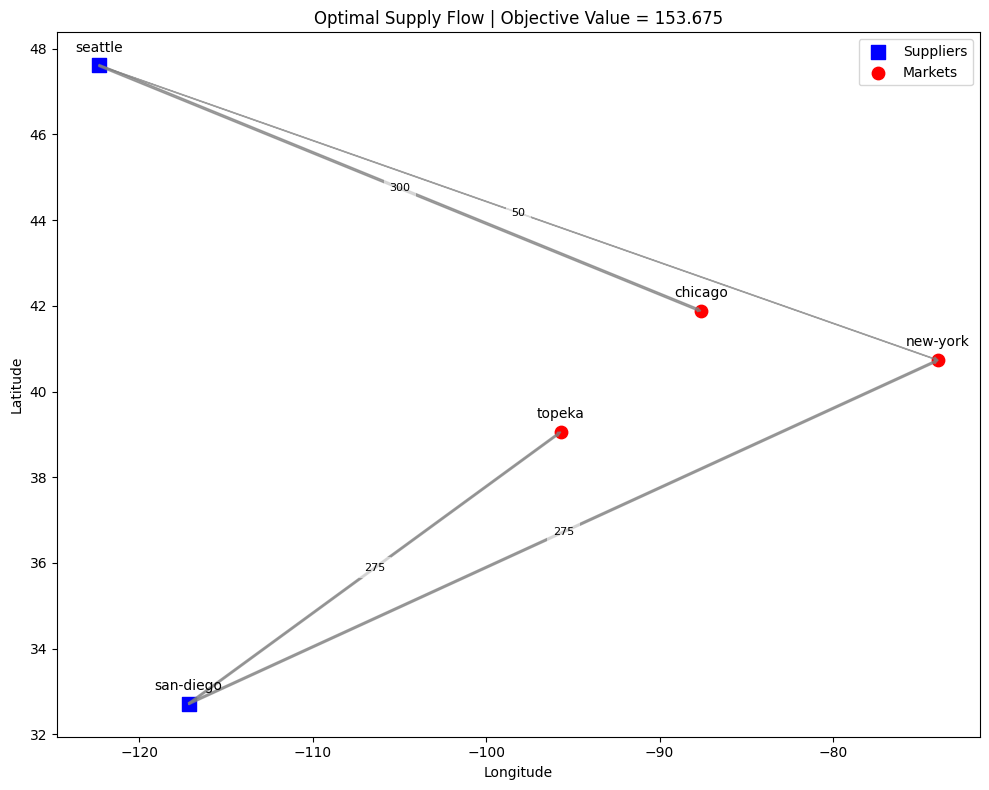

In [35]:
import matplotlib.pyplot as plt

suppliers = {
    "seattle": (47.608013, -122.335167),
    "san-diego": (32.715736, -117.161087),
}

markets = {
    "topeka": (39.056198, -95.695312),
    "chicago": (41.881832, -87.623177),
    "new-york": (40.730610, -73.935242),
}


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)

def sct_plt(data: dict, kwargs):
    names = data.keys()
    lat = [data[c][0] for c in names]
    long = [data[c][1] for c in names]
    ax.scatter(long, lat, **kwargs)
    for i, txt in enumerate(names):
        plt.annotate(
            txt,
            (long[i], lat[i]),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
        )

sct_plt(
    suppliers,
    kwargs={"color": "blue", "marker": "s", "s": 100, "label": "Suppliers"},
)
sct_plt(
    markets,
    kwargs={
        "color": "red",
        "marker": "o",
        "s": 80,
        "label": "Markets",
    },
)

df = x.l.records
df = df[df["level"] > 0]

for i, j, level in df.itertuples(index=False):
    lat_supplier, long_supplier = suppliers[i]
    lat_market, long_market = markets[j]
    arrow_width = level / max(df["level"]) * 0.05  # Scale width

    arr_args = {"head_width": 0.1,"head_length": 0.2,"fc": "gray",
                "ec": "gray","alpha": 0.7,"length_includes_head": True,
                "width": arrow_width,
    }

    plt.arrow(long_supplier,lat_supplier,
              long_market - long_supplier,
              lat_market - lat_supplier,
              **arr_args,
    )
    plt.text(
        (long_supplier + long_market) / 2,
        (lat_supplier + lat_market) / 2,
        str(int(level)),
        fontsize=8,
        ha="center",
        va="center",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
    )


plt.legend()
plt.title(f"Optimal Supply Flow | Objective Value = {transport.objective_value}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()